In [25]:
import re
import torch
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import random
import torch.nn.functional as F

In [126]:
def read_bird_names(fname):
    names = []
    with open(fname, 'r') as fp:
        next(fp)
        for line in fp:
            if ",Aves," in line:
                toks = line.split(',')
                try:
                    name = toks[17].lower()
                    #remove any non a-z, apostrophe or space
                    name = re.sub(r'[^a-z\s]', '', name)
                    name = re.sub(r'\s+', '_', name)
                    name = name.strip()
                    if len(name) > 3:
                        names.append(name)
                except:
                    pass
    return sorted(list(set(names)))
words = read_bird_names("/Users/satyajitgupte/code/birds/taxa_english.csv")
random.shuffle(words)

In [127]:
words[:5]

['whitebellied_flowerpecker',
 'grayheaded_canaryflycatcher',
 'mindanao_blue_fantail',
 'allens_woodpecker',
 'mascarene_petrel']

In [128]:
chars = sorted(list(set(''.join(words))))
# +1 for .
sz = len(chars) + 1
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'
stoi = {s:i for i,s in itos.items()}

In [129]:
def make_dataset(words, block_size=2):
    xs = []
    ys = []
    for word in words:
        #print(word)
        context = [0]*block_size
        for char in word + '.':
            ix = stoi[char]
            ys.append(ix)
            xs.append(context)
            #print(f"{''.join(itos[c] for c in context)}->{itos[ix]}")
            context = context[1:] + [ix]
    return torch.tensor(xs), torch.tensor(ys)

In [130]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = make_dataset(words[:n1], block_size=3)
Xdev,Ydev = make_dataset(words[n1:n2], block_size=3)
Xte,Yte = make_dataset(words[n2:], block_size=3)

In [131]:
Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([452618, 3]), torch.Size([56392, 3]), torch.Size([56150, 3]))

In [132]:
emb_size = 20
block_size = 3
hidden = 100

## Fix loss at init

In [133]:
# we expect the loss at init to be
-torch.tensor([1/sz]).log().item()

3.332204580307007

### experiment 1 - make final softmax less confident

In [134]:

for final_softmax_scale in [1.0, 0.1]:
    C = torch.randn(sz, emb_size)
    W1 = torch.randn(emb_size*block_size, hidden)
    b1 = torch.randn(hidden)
    W2 = torch.randn(hidden, sz)*final_softmax_scale
    b2 = torch.randn(sz)
    parameters = [C, W1, b1, W2, b2]
    for param in parameters:
        param.requires_grad = True
        
    # track stats
    lossi = []
    stepi = []
    
    # optimize
    for i in range(1):
    
        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (32,))
        # forward
        emb = C[Xtr[ix]].view(-1, emb_size*block_size)
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])

        # backward pass
        for param in parameters:
            param.grad = None
        loss.backward()

        # update
        for param in parameters:
            lr = 0.1
            param.data += -lr*param.grad
        lossi.append(loss.item())
        stepi.append(i)
    
    print(f"With scale={final_softmax_scale} loss at init={lossi[0]}")
    


With scale=1.0 loss at init=18.264406204223633
With scale=0.1 loss at init=3.9817371368408203


 ## expt 2 : see input to tanh with kaiming init
 ### normalize the weights by the square root of the fan in --> input to tanh becomes less saturated

kaiming init=False


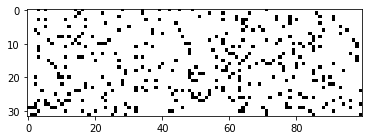

kaiming init=True


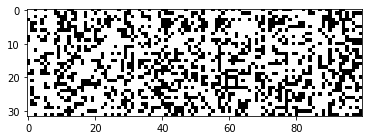

In [135]:

hacky_kaiming = [False, True]
for inits in hacky_kaiming:
    C = torch.randn(sz, emb_size)
    b1 = torch.randn(hidden)
    W1 = torch.randn(emb_size*block_size, hidden)
    W2 = torch.randn(hidden, sz)*0.1
    b2 = torch.randn(sz)
    if inits:
        W1 = 5/3*W1/(emb_size*block_size)**0.5


    parameters = [C, W1, b1, W2, b2]
    for param in parameters:
        param.requires_grad = True

    # track stats
    lossi = []
    stepi = []

    # optimize
    for i in range(1):

        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (32,))
        # forward
        emb = C[Xtr[ix]].view(-1, emb_size*block_size)
        hpreact = emb @ W1 + b1
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Ytr[ix])

        # backward pass
        for param in parameters:
            param.grad = None
        loss.backward()

        # update
        for param in parameters:
            lr = 0.1
            param.data += -lr*param.grad
        lossi.append(loss.item())
        stepi.append(i)
        #break
        print(f"kaiming init={inits}")
        plt.imshow(hpreact.abs() > 0.9, cmap='grey')
        plt.show()


### Batch Norm

In [136]:
C = torch.randn(sz, emb_size)
b1 = torch.randn(hidden)
W1 = torch.randn(emb_size*block_size, hidden)
W2 = torch.randn(hidden, sz)*0.1
b2 = torch.randn(sz)

#BatchNorm paramaets
bngain = torch.ones(1, hidden)
bnbias = torch.zeros(1, hidden)
bnmean_running = torch.ones(1, hidden)
bnstd_running = torch.zeros(1, hidden)

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for param in parameters:
    param.requires_grad = True

In [137]:
# track stats
lossi = []
stepi = []

# optimize
for i in range(200000):

    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    # forward
    emb = C[Xtr[ix]].view(-1, emb_size*block_size)
    hpreact = emb @ W1 + b1
    
    #batchnorm
    # column-wise means 
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    
    hpreact = bngain*((hpreact-bnmeani)/bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi

    # non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for param in parameters:
        param.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for param in parameters:     
        param.data += -lr*param.grad
    lossi.append(loss.item())
    stepi.append(i)
    

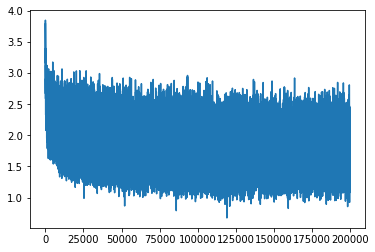

In [138]:
plt.plot(stepi, lossi)

In [139]:
@torch.no_grad
def evaluate_loss(split):
    X, Y = {
        "train": (Xtr, Ytr),
        "dev": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    emb = C[X].view(-1, emb_size*block_size)
    hpreact = emb @ W1 + b1
    hpreact = bngain*((hpreact-bnmean_running)/bnstd_running) + bnbias
    
    # non-linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(split, "Loss=", loss.item())
    
    
    

In [140]:
evaluate_loss("train")
evaluate_loss("dev")

train Loss= 1.6559501886367798
dev Loss= 1.68363356590271


### PyTorchifying code 

In [230]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weights = torch.randn(fan_in, fan_out)/(fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #batchnorm params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers trained with momentum updates
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)
        
    def __call__(self, x):
        
        if self.training:
            #batch mean and var
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
        
        

In [324]:

def make_model(use_batchnorm, use_init_gain):
    n_embed = 10
    n_hidden = 100
    block_size = 3
    C = torch.randn((sz, n_embed))
    if use_batchnorm:
        layers = [
            Linear(n_embed*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
            Linear(n_hidden, sz), BatchNorm1d(sz),
        ]
    else:
        layers = [
            Linear(n_embed*block_size, n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), Tanh(),
            Linear(n_hidden, n_hidden), Tanh(),
            Linear(n_hidden, sz), BatchNorm1d(sz),
        ]

    with torch.no_grad():
        # make the last layer less confident
        layers[-1].gamma *= 0.1
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                if use_init_gain:
                    layer.weights *= 5/3
                else:
                    layer.weights *= 1

    parameters = [C] + [p for layer in layers for p in layer.parameters()]
    for param in parameters:
        param.requires_grad = True

    print("Num Parameters", sum(p.nelement() for p in parameters))
    return layers, parameters


In [354]:
def optimize(C, layers, parameters):

    # track stats
    lossi = []
    stepi = []
    ud = []
    max_steps = 200000

    # optimize
    for i in range(100):

        # minibatch
        ix = torch.randint(0, Xtr.shape[0], (32,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        # forward
        emb = C[Xb]
        x = emb.view(-1, n_embed*block_size)

        for layer in layers:
            x = layer(x)

        loss = F.cross_entropy(x, Yb)

        # backward pass

        # retain grad for debug
        for layer in layers:
            layer.out.retain_grad()
        for param in parameters:
            param.grad = None
        loss.backward()

        # update
        lr = 0.1 if i < 100000 else 0.01
        for param in parameters:     
            param.data += -lr*param.grad
        if i % 10000 == 0:
            print(i, loss.item())
        lossi.append(loss.log10().item())
        stepi.append(i)
        #log parameter updates
        for p in parameters:
            update_std = (-lr * param.grad).std()
            param_std = (param.data).std()
            ud.append((update_std/param_std).log10().item())
            
            
        
        if i > 1000:
            break 
    return C, layers, parameters, stepi, lossi 

In [355]:
def visualize_tanh_activations(layers, title_text):
    ## visualize hisograms
    plt.figure(figsize=(20, 4))
    legends = []
    # exculde last layer
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out
            print("Layer%d, name=%s mean=%.2f, std=%.2f perc saturated=%.2f"%(i, layer.__class__.__name__, t.mean(), t.var(), (t.abs()>0.97).float().mean()*100))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append("Layer{} {}".format(i, layer.__class__.__name__))
        plt.legend(legends)
        plt.title(title_text)
    plt.show()
        

In [356]:
def visualize_backward_gradients(layers, title_text):
    """ gradients flowing baclward through tanh """
    ## visualize hisograms
    plt.figure(figsize=(20, 4))
    legends = []
    # exculde last layer
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out.grad
            print("Layer%d, name=%s mean=%.2f, std=%.2f"%(i, layer.__class__.__name__, t.mean(), t.var()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append("Layer{} {}".format(i, layer.__class__.__name__))
        plt.legend(legends)
        plt.title(title_text)
    plt.show()

In [357]:
def visualize_parameter_gradients(parameters, title_text):
    """param gradients """
    plt.figure(figsize=(20, 4))
    legends = []
    for i, param in enumerate(parameters):
        if param.ndim == 2:
            t = param.grad
            print("weight %10s | mean %+f | std %f | grad:data ratio %e"%(tuple(param.shape), t.mean(), t.var(), t.var()/param.data.var()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append("Param{} {}".format(i, tuple(param.shape)))
        plt.legend(legends)
        plt.title(title_text)
    plt.show()
            
                  

Num Parameters 47664
0 3.346161365509033
Layer2, name=Tanh mean=0.00, std=0.39 perc saturated=3.22
Layer5, name=Tanh mean=0.00, std=0.40 perc saturated=3.03
Layer8, name=Tanh mean=-0.00, std=0.41 perc saturated=2.19
Layer11, name=Tanh mean=-0.00, std=0.40 perc saturated=2.75
Layer14, name=Tanh mean=0.00, std=0.40 perc saturated=2.91


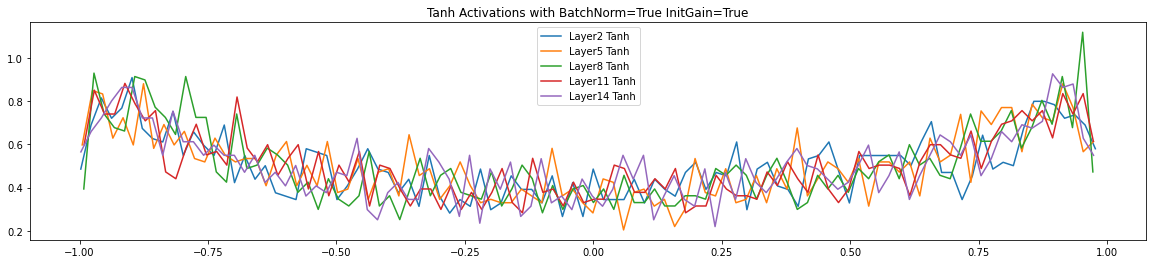

Layer2, name=Tanh mean=-0.00, std=0.00
Layer5, name=Tanh mean=-0.00, std=0.00
Layer8, name=Tanh mean=0.00, std=0.00
Layer11, name=Tanh mean=-0.00, std=0.00
Layer14, name=Tanh mean=-0.00, std=0.00


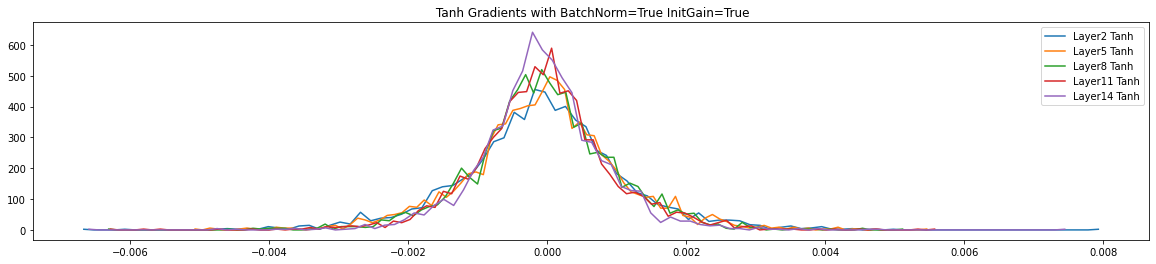

weight   (28, 10) | mean +0.000000 | std 0.000007 | grad:data ratio 8.254370e-06
weight  (30, 100) | mean -0.000051 | std 0.000008 | grad:data ratio 8.629748e-05
weight (100, 100) | mean +0.000001 | std 0.000006 | grad:data ratio 2.268331e-04
weight (100, 100) | mean +0.000019 | std 0.000006 | grad:data ratio 2.158046e-04
weight (100, 100) | mean -0.000000 | std 0.000006 | grad:data ratio 1.976975e-04
weight (100, 100) | mean +0.000014 | std 0.000005 | grad:data ratio 1.818067e-04
weight  (100, 28) | mean -0.000062 | std 0.000012 | grad:data ratio 4.458252e-04


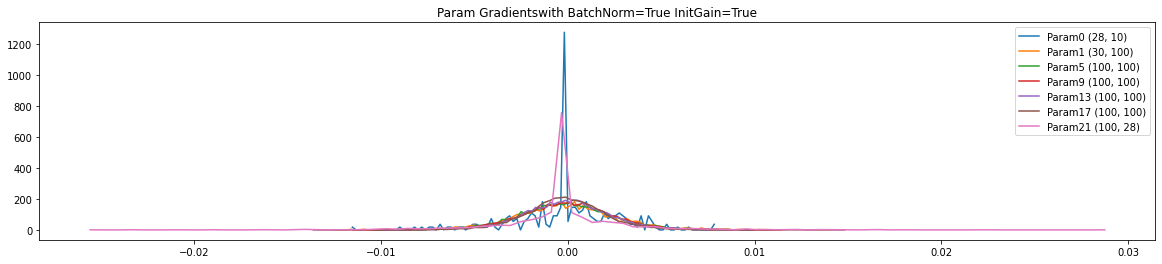

Num Parameters 46664
0 3.3393259048461914
Layer1, name=Tanh mean=0.05, std=0.58 perc saturated=23.53
Layer3, name=Tanh mean=0.02, std=0.48 perc saturated=10.19
Layer5, name=Tanh mean=-0.00, std=0.46 perc saturated=8.16
Layer7, name=Tanh mean=0.02, std=0.45 perc saturated=7.06
Layer9, name=Tanh mean=0.02, std=0.44 perc saturated=6.12


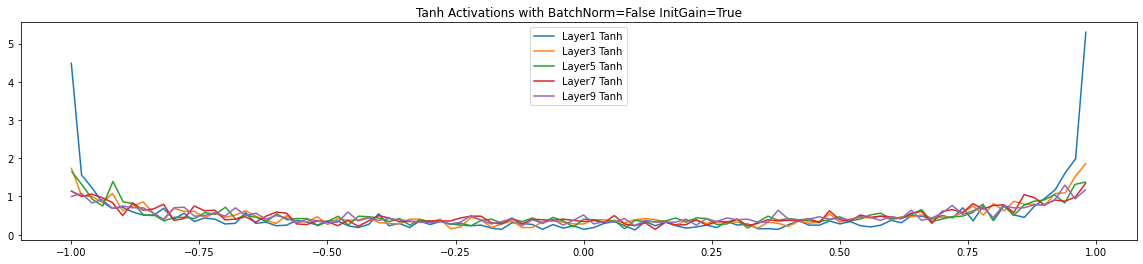

Layer1, name=Tanh mean=-0.00, std=0.00
Layer3, name=Tanh mean=-0.00, std=0.00
Layer5, name=Tanh mean=0.00, std=0.00
Layer7, name=Tanh mean=-0.00, std=0.00
Layer9, name=Tanh mean=-0.00, std=0.00


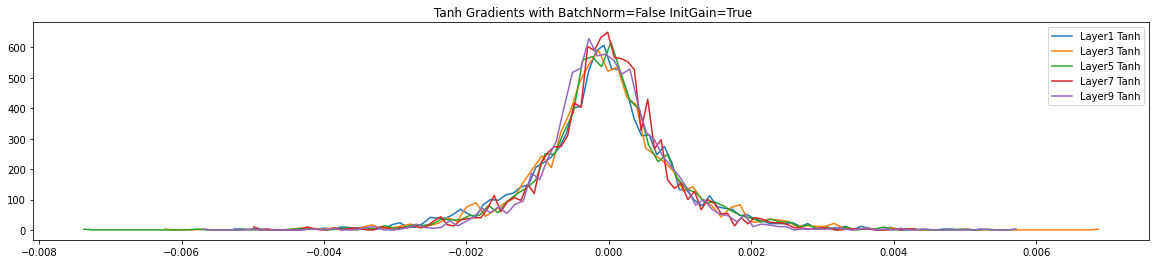

weight   (28, 10) | mean +0.000048 | std 0.000011 | grad:data ratio 1.107438e-05
weight  (30, 100) | mean -0.000146 | std 0.000011 | grad:data ratio 1.251345e-04
weight (100, 100) | mean -0.000015 | std 0.000009 | grad:data ratio 3.192742e-04
weight (100, 100) | mean +0.000056 | std 0.000006 | grad:data ratio 2.165343e-04
weight (100, 100) | mean +0.000002 | std 0.000005 | grad:data ratio 1.782292e-04
weight (100, 100) | mean +0.000012 | std 0.000004 | grad:data ratio 1.447794e-04
weight  (100, 28) | mean +0.000004 | std 0.000012 | grad:data ratio 4.232085e-04


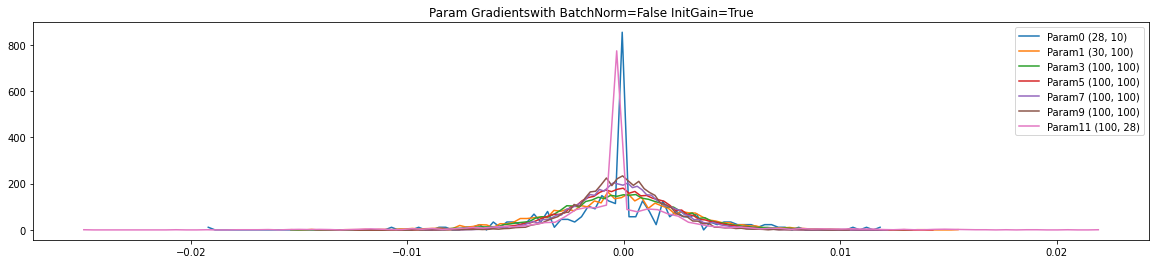

Num Parameters 47664
0 3.334177255630493
Layer2, name=Tanh mean=-0.00, std=0.39 perc saturated=3.38
Layer5, name=Tanh mean=-0.00, std=0.39 perc saturated=3.25
Layer8, name=Tanh mean=0.00, std=0.40 perc saturated=3.06
Layer11, name=Tanh mean=-0.00, std=0.40 perc saturated=2.47
Layer14, name=Tanh mean=0.00, std=0.41 perc saturated=2.56


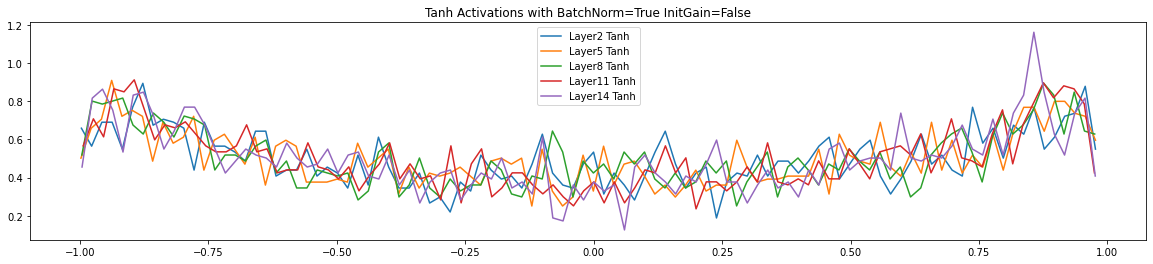

Layer2, name=Tanh mean=0.00, std=0.00
Layer5, name=Tanh mean=-0.00, std=0.00
Layer8, name=Tanh mean=-0.00, std=0.00
Layer11, name=Tanh mean=0.00, std=0.00
Layer14, name=Tanh mean=-0.00, std=0.00


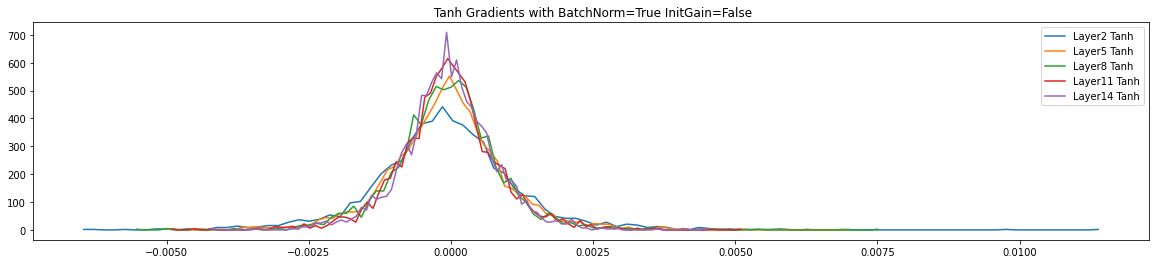

weight   (28, 10) | mean +0.000000 | std 0.000011 | grad:data ratio 1.122561e-05
weight  (30, 100) | mean -0.000010 | std 0.000025 | grad:data ratio 7.116231e-04
weight (100, 100) | mean -0.000030 | std 0.000019 | grad:data ratio 1.858662e-03
weight (100, 100) | mean +0.000007 | std 0.000015 | grad:data ratio 1.462454e-03
weight (100, 100) | mean +0.000024 | std 0.000012 | grad:data ratio 1.230694e-03
weight (100, 100) | mean -0.000000 | std 0.000011 | grad:data ratio 1.092357e-03
weight  (100, 28) | mean +0.000088 | std 0.000031 | grad:data ratio 3.064502e-03


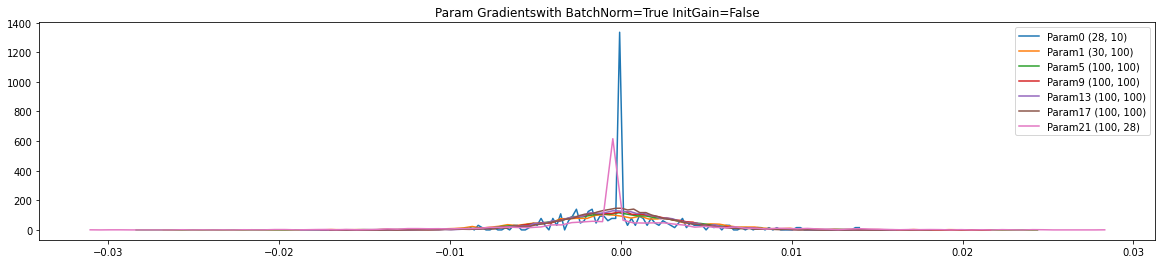

Num Parameters 46664
0 3.3323493003845215
Layer1, name=Tanh mean=-0.02, std=0.39 perc saturated=3.50
Layer3, name=Tanh mean=-0.01, std=0.24 perc saturated=0.22
Layer5, name=Tanh mean=-0.00, std=0.19 perc saturated=0.03
Layer7, name=Tanh mean=-0.02, std=0.14 perc saturated=0.00
Layer9, name=Tanh mean=-0.01, std=0.11 perc saturated=0.00


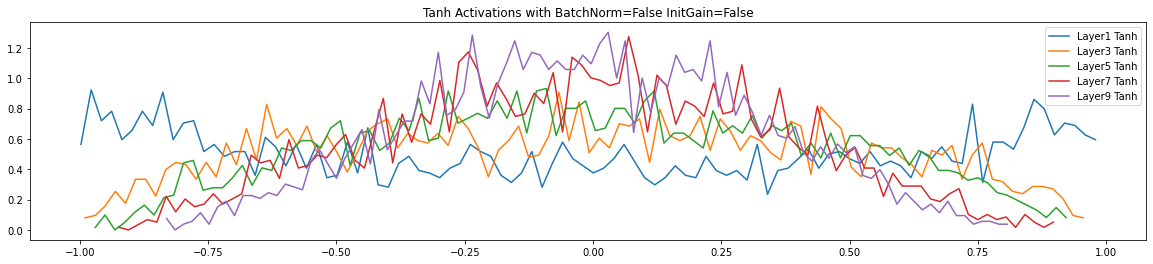

Layer1, name=Tanh mean=0.00, std=0.00
Layer3, name=Tanh mean=-0.00, std=0.00
Layer5, name=Tanh mean=0.00, std=0.00
Layer7, name=Tanh mean=-0.00, std=0.00
Layer9, name=Tanh mean=-0.00, std=0.00


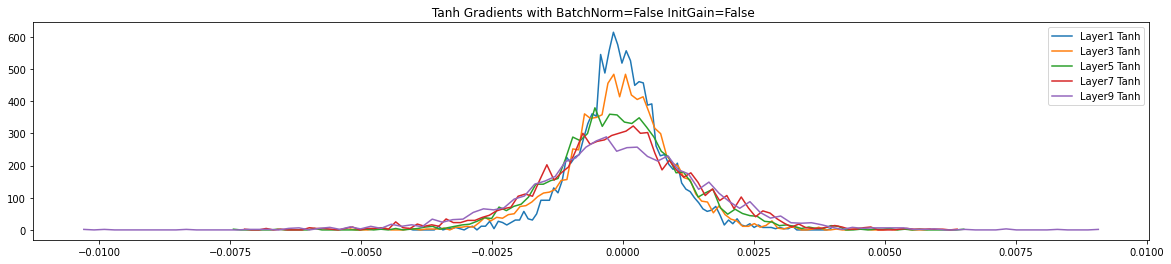

weight   (28, 10) | mean +0.000183 | std 0.000004 | grad:data ratio 4.072619e-06
weight  (30, 100) | mean +0.000009 | std 0.000009 | grad:data ratio 2.669776e-04
weight (100, 100) | mean +0.000030 | std 0.000007 | grad:data ratio 7.216998e-04
weight (100, 100) | mean -0.000028 | std 0.000007 | grad:data ratio 6.734178e-04
weight (100, 100) | mean +0.000053 | std 0.000008 | grad:data ratio 7.933723e-04
weight (100, 100) | mean +0.000013 | std 0.000009 | grad:data ratio 9.439226e-04
weight  (100, 28) | mean -0.000061 | std 0.000027 | grad:data ratio 2.614156e-03


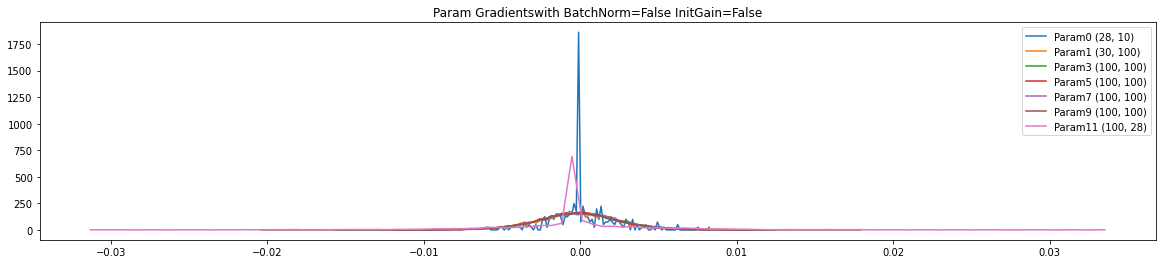

In [358]:
for use_init_gain in [True, False]:
    for use_batchnorm in [True, False]:
        layers, parameters = make_model(use_batchnorm, use_init_gain)
        C, layers, parameters, stepi, lossi = optimize(parameters[0], layers, parameters)
        visualize_tanh_activations(layers, title_text='Tanh Activations with BatchNorm={} InitGain={}'.format(use_batchnorm, use_init_gain))
        visualize_backward_gradients(layers, title_text=' Tanh Gradients with BatchNorm={} InitGain={}'.format(use_batchnorm, use_init_gain))
        visualize_parameter_gradients(parameters, title_text='Param Gradientswith BatchNorm={} InitGain={}'.format(use_batchnorm, use_init_gain))